<a href="https://colab.research.google.com/github/venkateshgali91/SRIP/blob/main/notebooks/colab-github-demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Implement two hidden layers neural network classifier from scratch in JAX


In [2]:
import numpy as np
import jax.numpy as jnp
from jax.scipy.special import logsumexp
import jax
from jax import jit, vmap, pmap, grad, value_and_grad

from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

In [3]:
seed = 0
mnist_img_size = (28, 28)

def init_MLP(layer_widths, parent_key, scale=0.01):

    p = []
    keys = jax.random.split(parent_key, num=len(layer_widths)-1)

    for in_width, out_width, key in zip(layer_widths[:-1], layer_widths[1:], keys):
        weight_key, bias_key = jax.random.split(key)
        p.append([
                       scale*jax.random.normal(weight_key, shape=(out_width, in_width)),
                       scale*jax.random.normal(bias_key, shape=(out_width,))
                       ]
        )

    return p
key = jax.random.PRNGKey(seed)
MLP = init_MLP([784, 256, 512, 16], key)
print(jax.tree_map(lambda x: x.shape, MLP)) 

[[(256, 784), (256,)], [(512, 256), (512,)], [(16, 512), (16,)]]


In [4]:
def MLP_predict(p, x):
    hidden_layer= p[:-1]

    activation_function = x
    for w, b in hidden_layer:
        activation_function = jax.nn.relu(jnp.dot(w, activation_function) + b)

    w_last, b_last = p[-1]
    log = jnp.dot(w_last, activation_function) + b_last

    return log - logsumexp(log)

# tests
 #example

d_img = np.random.randn(np.prod(mnist_img_size))
print(d_img.shape)

prediction = MLP_predict(MLP, d_img)
print(prediction.shape)

# test batched function
batched_MLP_predict = vmap(MLP_predict, in_axes=(None, 0))

d_img = np.random.randn(16, np.prod(mnist_img_size))
print(d_img.shape)
prediction = batched_MLP_predict(MLP, d_img)


(784,)
(16,)
(16, 784)


In [10]:
def custom_transform(x):
    return np.ravel(np.array(x, dtype=np.float32))

def custom_collate(batch):
    trans_data = list(zip(*batch))

    labels = np.array(trans_data[1])
    imgs = np.stack(trans_data[0])

    return imgs, labels
  # alternate method
''' we can also load the data in pandas library by using the command 
df=pd.read_csv("mnist_dataset.csv") and by using keras we train model by using function callled x_train,x_test,y_train,y_test'''
# using dataloader 
batch_size = 64
train_dataset = MNIST(root='train_mnist', train=True, download=True, transform=custom_transform)
test_dataset = MNIST(root='test_mnist', train=False, download=True, transform=custom_transform)

train_loader = DataLoader(train_dataset, batch_size, shuffle=True, collate_fn=custom_collate, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size, shuffle=False, collate_fn=custom_collate, drop_last=True)

# test
batch_data = next(iter(train_loader))
imgs = batch_data[0]
lbls = batch_data[1]
print(imgs.shape, imgs[0].dtype, lbls.shape, lbls[0].dtype)

# optimization - loading the whole dataset into memory
train_images = jnp.array(train_dataset.data).reshape(len(train_dataset), -1)
train_lbls = jnp.array(train_dataset.targets)

test_images = jnp.array(test_dataset.data).reshape(len(test_dataset), -1)
test_lbls = jnp.array(test_dataset.targets)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting train_mnist/MNIST/raw/train-images-idx3-ubyte.gz to train_mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting train_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to train_mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting train_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to train_mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting train_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to train_mnist/MNIST/raw



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting test_mnist/MNIST/raw/train-images-idx3-ubyte.gz to test_mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting test_mnist/MNIST/raw/train-labels-idx1-ubyte.gz to test_mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting test_mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to test_mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting test_mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to test_mnist/MNIST/raw

(64, 784) float32 (64,) int64


In [11]:
num_epochs = 10
# here we use jax to obtain optimization of the model 
def loss_function(pam , imgs, gt_lbls):
    predictions = batched_MLP_predict(pam, imgs)

    return -jnp.mean(predictions * gt_lbls)

def accuracy(p, dataset_img, dataset_lbls):
    pred_classes = jnp.argmax(batched_MLP_predict(p, dataset_img), axis=1)
    return jnp.mean(dataset_lbls == pred_classes)

@jit
def update(p, imgs, gt_lbls, lr=0.01):
    loss, grads = value_and_grad(loss_function)(p, imgs, gt_lbls)

    return loss, jax.tree_multimap(lambda p, g: p - lr*g, p, grads)
# now we are creating multilayer perceptron layer in our neural networks
MLP_params = init_MLP([np.prod(mnist_img_size), 512, 256, len(MNIST.classes)], key)

for epoch in range(num_epochs):

    for cnt, (imgs, lbls) in enumerate(train_loader):

        gt_labels = jax.nn.one_hot(lbls, len(MNIST.classes))
        
        loss, MLP_params = update(MLP_params, imgs, gt_labels)
        
        if cnt % 50 == 0:
            print(loss)

    print(f'Epoch {epoch}, train acc = {accuracy(MLP_params, train_images, train_lbls)} test acc = {accuracy(MLP_params, test_images, test_lbls)}')

0.23085268
0.098616324
0.06307974
0.048450995
0.03485667
0.032426458
0.038813587
0.048160266
0.034056913
0.014549429
0.03212477
0.03783384
0.031175015
0.033351954
0.020583656
0.011617589
0.020779317
0.017046912
0.017000917
Epoch 0, train acc = 0.9275333285331726 test acc = 0.9271000027656555
0.025368651
0.031237999
0.016033525
0.02015927
0.01757895
0.023634523
0.021426713
0.017416505
0.029429737
0.01290167
0.025351673
0.010697312
0.0253982
0.02305391
0.019579867
0.011774457
0.023843916
0.010544366
0.007995479
Epoch 1, train acc = 0.953166663646698 test acc = 0.9503999948501587
0.01301075
0.0133524565
0.010710927
0.033876628
0.013919068
0.011282398
0.015747841
0.041638553
0.0096974885
0.010695137
0.016207213
0.023376957
0.011268898
0.015818616
0.010129382
0.01580741
0.009439173
0.01122542
0.016105471
Epoch 2, train acc = 0.9623500108718872 test acc = 0.9571999907493591
0.01017618
0.012433302
0.009225624
0.0045131617
0.009200977
0.016226027
0.0059469244
0.002853193
0.020310784
0.02602318

(28, 28)
pred 1
gt 1


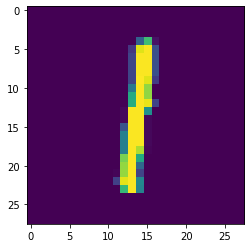

In [22]:
img1, lbl1 = next(iter(test_loader))
img1 = imgs[0].reshape(mnist_img_size)
gt_lbl1 = lbl1[2]
print(img1.shape)

import matplotlib.pyplot as plt

pred = jnp.argmax(MLP_predict(MLP_params, np.ravel(img1)))
print('pred', pred)
print('gt', gt_lbl1)

plt.imshow(img1); plt.show()

Visualizations using matplotlib

(512, 784)
(28, 28)


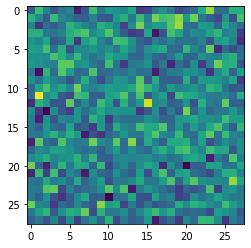

In [21]:
w = MLP_params[0][0]
print(w.shape)

w_single = w[500, :].reshape(mnist_img_size)
print(w_single.shape)
plt.imshow(w_single); plt.show()